# Τελική Εργασία
### _Ευάγγελος Μπαρμπαλιάς, ΑΜ : 2766_


In [1]:
import os
import sys
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

from sklearn.decomposition import PCA

In [2]:
print(sys.version)
print(tf.__version__)

3.6.10 | packaged by conda-forge | (default, Apr 24 2020, 16:44:11) 
[GCC 7.3.0]
1.15.0


### Η κλάση αυτή είναι υπέυθυνη για να φορτώσει το μοντέλο που της δίνουμε και να εκτελέσει συναρτήσεις ώστε βγάλει αποτελέσματα.
* Παίρνει σαν όρισμα το path του .tar μοντέλου, το αποσυμπιέζει και εξάγει το frozen graph.
* Η συνάρτηση run εφαρμόζεται για μια εικόνα. Αρχικά δημιουργεί segmentation map  για τον τελικό τανυστή (OUTPUT_TENSOR)
Στη συνέχεια 'διατρέχει' ολόκληρο το γράφο υπολογισμού, τυπώνοντας τα ονόματα των ενδιάμεσων κόμβων και τα χαρακτηριστικά τους. Εκτελώ session run για 2η φορά,
αλλά αυτή τη φορά με παράμετρο έναν ενδιαμέσο τανυστή, τον 'decoder/decoder_conv1_pointwise/Conv2D:0', όπου μέσω της διαδικασίας αυτής παίρων επίσης ένα segmentation map
* Τέλος, αφού προσαρμόζω τον τανυστή και υπολογίζω τα απαιτούμενα για να εκτελέσω PCA, εκτελώ PCA και εξάγω μια ψευδοχρωματισμένη εικόνα, όπου αντικείμενα παρόμοιας σημασιολογίας γενικά θα αντιστοιχούν σε παρόμοιο χρώμα
* Αποθηκεύεται ολόκληρος ο γράφος υπολογισμού στον δίσκο
     

In [3]:
class DeepLabModel(object):
  
  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()     # the dataflow graph

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

    

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    
    
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
   

    print("\n\t****CALCULATING ALL LAYERS/TENSORS*****\n\n")
    for op in self.graph.get_operations():
      print (op.name,' | VALUES | : ',op.values())
      if op.name == 'decoder/decoder_conv0_pointwise/Conv2D':
        x = op.values()

    print("\nSpecific tensor found : ",x)
    
    inter_layer_batch_seg_map = self.sess.run(
        'decoder/decoder_conv1_pointwise/Conv2D:0',
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    inter_seg_map = inter_layer_batch_seg_map[0]

    print('Inter Layer seg_map shape : ',inter_layer_batch_seg_map.shape)

    N = inter_layer_batch_seg_map.shape[1]*inter_layer_batch_seg_map.shape[2]
    C = inter_layer_batch_seg_map.shape[-1]
    
    print("N = ", N)
    print("C = ", C)

    X = np.reshape(inter_layer_batch_seg_map, [N, C])

    print('Data shape before PCA : {}'.format(inter_layer_batch_seg_map.shape))
    print('\nPerforming PCA .... \n')
    Xreduced = PCA(n_components=3).fit_transform(X)
    print('Data shape after PCA : {}'.format(Xreduced.shape))


    deepfeats_reduced = np.reshape(Xreduced, [inter_layer_batch_seg_map.shape[1], inter_layer_batch_seg_map.shape[2], 3])
    print('Reduced shape : ',deepfeats_reduced.shape)
    plt.imshow(deepfeats_reduced)
    plt.show()

    print("\n\n\n... ENTIRE GRAPH IS SAVED ...\n")
    writer = tf.summary.FileWriter('/tmp/tftut/1')
    writer.add_graph(self.sess.graph)

    return resized_image, seg_map
    


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  print("\n... VISUALIZING IMAGE ...\n")

  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()

In [4]:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1) 
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

MODEL_NAME = 'xception_coco_voctrainaug' # @param 'mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval'

MODEL = DeepLabModel("/home/vaggelisbarb/models/research/deeplab/datasets/pascal_voc_seg/init_models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz")



#### Συνάρτηση run_image : 
 * Μέσω αυτής καλείται και η συνάρτηση run του μοντέλου που δημιουργήσαμε πριν.
 * Παίρνει σαν όρισμα το path του image. 
 * Τέλος καλεί την vis_segmentation για το τελικό αποτέλεσμα, δίνοντας την εικόνα πριν και μετά της σημασιολογικής κατάτμησης

In [5]:
def run_image(image_path): 
    try: 
        orignal_im = Image.open(image_path) 
    except IOError: 
        print('Failed to read image from %s.' % image_path) 
        return 
    print('running deeplab on image %s...' % image_path) 
    resized_im, seg_map = MODEL.run(orignal_im)

    vis_segmentation(resized_im, seg_map)


### Performimg PCA on deep features of inter layer : 'decoder/decoder_conv1_pointwise/Conv2D:0'
### & Semantic segmentation on 5 images

  (<tf.Tensor 'aspp3_pointwise/BatchNorm/moving_variance:0' shape=(256,) dtype=float32>,)
aspp3_pointwise/BatchNorm/moving_variance/read  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/BatchNorm/moving_variance/read:0' shape=(256,) dtype=float32>,)
aspp3_pointwise/BatchNorm/FusedBatchNorm  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:0' shape=(1, 65, 65, 256) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:1' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:2' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:3' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:4' shape=(256,) dtype=float32>)
aspp3_pointwise/Relu  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/Relu:0' shape=(1, 65, 65, 256) dtype=float32>,)
concat/axis  | VALUES | :  (<tf.Tensor 'concat/axis:0' shape=() dtype=int32>,)
concat  | VALUES | :  (<tf.Tensor 'concat:0' shape=(1, 65, 65, 1280) dt

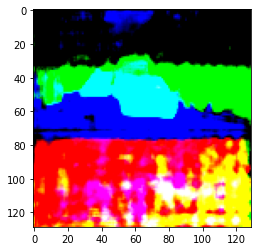




... ENTIRE GRAPH IS SAVED ...


... VISUALIZING IMAGE ...



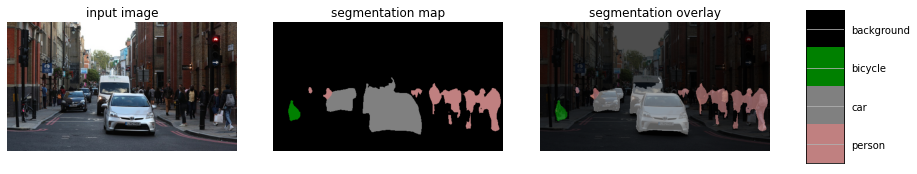

In [6]:
run_image('/home/vaggelisbarb/teliki-askisi-me-tensorflow-vaggelisbarb/city.jpeg')


  (<tf.Tensor 'aspp3_pointwise/BatchNorm/moving_variance:0' shape=(256,) dtype=float32>,)
aspp3_pointwise/BatchNorm/moving_variance/read  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/BatchNorm/moving_variance/read:0' shape=(256,) dtype=float32>,)
aspp3_pointwise/BatchNorm/FusedBatchNorm  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:0' shape=(1, 65, 65, 256) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:1' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:2' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:3' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:4' shape=(256,) dtype=float32>)
aspp3_pointwise/Relu  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/Relu:0' shape=(1, 65, 65, 256) dtype=float32>,)
concat/axis  | VALUES | :  (<tf.Tensor 'concat/axis:0' shape=() dtype=int32>,)
concat  | VALUES | :  (<tf.Tensor 'concat:0' shape=(1, 65, 65, 1280) dt

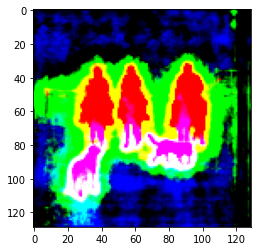




... ENTIRE GRAPH IS SAVED ...


... VISUALIZING IMAGE ...



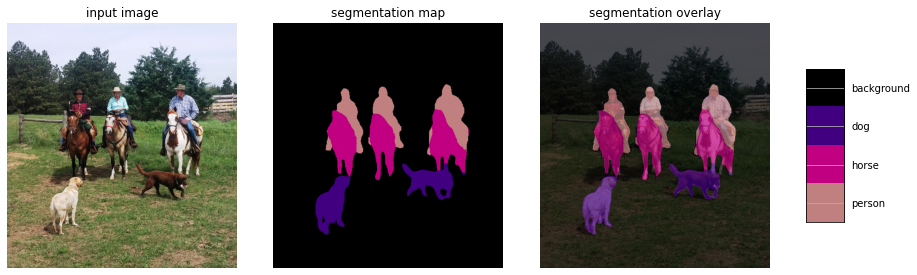

In [7]:
run_image('/home/vaggelisbarb/teliki-askisi-me-tensorflow-vaggelisbarb/cowboy.jpg')

  (<tf.Tensor 'aspp3_pointwise/BatchNorm/moving_variance:0' shape=(256,) dtype=float32>,)
aspp3_pointwise/BatchNorm/moving_variance/read  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/BatchNorm/moving_variance/read:0' shape=(256,) dtype=float32>,)
aspp3_pointwise/BatchNorm/FusedBatchNorm  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:0' shape=(1, 65, 65, 256) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:1' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:2' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:3' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:4' shape=(256,) dtype=float32>)
aspp3_pointwise/Relu  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/Relu:0' shape=(1, 65, 65, 256) dtype=float32>,)
concat/axis  | VALUES | :  (<tf.Tensor 'concat/axis:0' shape=() dtype=int32>,)
concat  | VALUES | :  (<tf.Tensor 'concat:0' shape=(1, 65, 65, 1280) dt

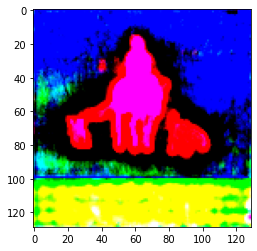




... ENTIRE GRAPH IS SAVED ...


... VISUALIZING IMAGE ...



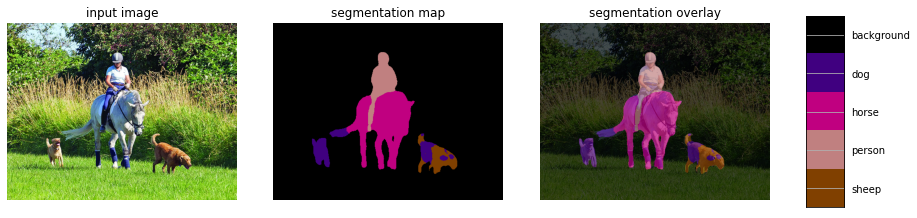

In [8]:
run_image('/home/vaggelisbarb/teliki-askisi-me-tensorflow-vaggelisbarb/rider.jpg')

  (<tf.Tensor 'aspp3_pointwise/BatchNorm/moving_variance:0' shape=(256,) dtype=float32>,)
aspp3_pointwise/BatchNorm/moving_variance/read  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/BatchNorm/moving_variance/read:0' shape=(256,) dtype=float32>,)
aspp3_pointwise/BatchNorm/FusedBatchNorm  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:0' shape=(1, 65, 65, 256) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:1' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:2' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:3' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:4' shape=(256,) dtype=float32>)
aspp3_pointwise/Relu  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/Relu:0' shape=(1, 65, 65, 256) dtype=float32>,)
concat/axis  | VALUES | :  (<tf.Tensor 'concat/axis:0' shape=() dtype=int32>,)
concat  | VALUES | :  (<tf.Tensor 'concat:0' shape=(1, 65, 65, 1280) dt

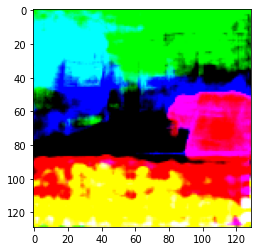




... ENTIRE GRAPH IS SAVED ...


... VISUALIZING IMAGE ...



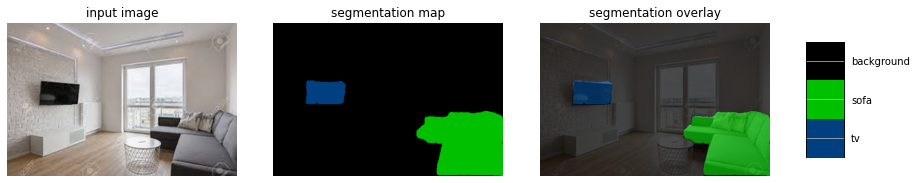

In [9]:
run_image('/home/vaggelisbarb/teliki-askisi-me-tensorflow-vaggelisbarb/images.jpeg')

  (<tf.Tensor 'aspp3_pointwise/BatchNorm/moving_variance:0' shape=(256,) dtype=float32>,)
aspp3_pointwise/BatchNorm/moving_variance/read  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/BatchNorm/moving_variance/read:0' shape=(256,) dtype=float32>,)
aspp3_pointwise/BatchNorm/FusedBatchNorm  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:0' shape=(1, 65, 65, 256) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:1' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:2' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:3' shape=(256,) dtype=float32>, <tf.Tensor 'aspp3_pointwise/BatchNorm/FusedBatchNorm:4' shape=(256,) dtype=float32>)
aspp3_pointwise/Relu  | VALUES | :  (<tf.Tensor 'aspp3_pointwise/Relu:0' shape=(1, 65, 65, 256) dtype=float32>,)
concat/axis  | VALUES | :  (<tf.Tensor 'concat/axis:0' shape=() dtype=int32>,)
concat  | VALUES | :  (<tf.Tensor 'concat:0' shape=(1, 65, 65, 1280) dt

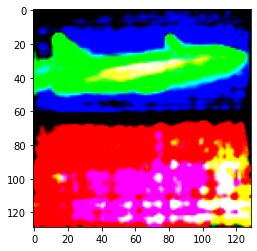




... ENTIRE GRAPH IS SAVED ...


... VISUALIZING IMAGE ...



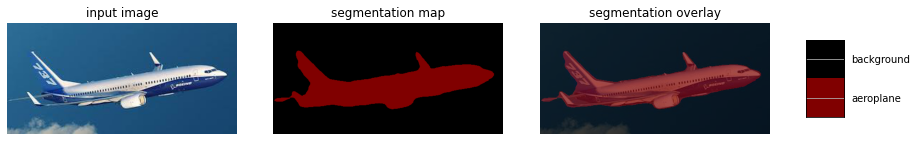

In [10]:
run_image('/home/vaggelisbarb/teliki-askisi-me-tensorflow-vaggelisbarb/airplanes.jpeg')